## Problem Statement  

Suppose $S_1$ and $S_2$ are driven by the dynamics:  

$$\frac{dS_i(t)}{S_i(t)} = (r - q_i) \, dt + \boldsymbol{\sigma}_i^\top d\boldsymbol{W}^Q(t)$$

for i = 1, 2, where:  
- $q_i$ is the dividend yield,  
- $\boldsymbol{W}^Q$ is a 2-dimensional standard Brownian motion under the risk-neutral measure $Q$,  
- $\boldsymbol{\sigma}_1 = \begin{bmatrix} v_1, 0 \end{bmatrix},$  
- $\boldsymbol{\sigma}_2 = \begin{bmatrix} \rho v_2, \sqrt{1 - \rho^2} v_2 \end{bmatrix},$  
- $\rho \in (-1, 1),$ and $v_1, v_2 > 0.$

Here, $r$ denotes the risk-free interest rate.  

---

## Barrier Option and European Call Option  

Let $T = 1 \, \text{year}$ and consider a barrier $b > S_1(0)$ on the first asset $S_1$, monitored at discrete times $t_m = m \frac{T}{M}$ for $m = 1, \dots, M$. The barrier is activated if:  

$$M_1(T) = \max \{ S_1(t) : t \in \{t_1, \dots, t_M\} \} \geq b.$$  

We also consider a standard European call option on $S_2$ with maturity $T$ and strike price $K$, which has the payoff:  

$$
c(T) = \max \{ S_2(T) - K, 0 \}.
$$  

Now, we define the $S_1$-knock-in call option on $S_2$, which has the payoff:  

$$
X(T) = c(T) \cdot \mathbb{I}_{\{M_1(T) \geq b\}},
$$  

where $\mathbb{I}_{\{M_1(T) \geq b\}}$ is the indicator function that takes the value 1 if the barrier $b$ is breached, and 0 otherwise.  

---

## Task  

Compute the Monte Carlo estimate of the price of the knock-in call option $X(T)$ for different monitoring frequencies (e.g., weekly or monthly) and for various values of volatilities $(v_1, v_2)$ and correlation $( \rho)$.  


In [1]:
# import the libraries we are going to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D


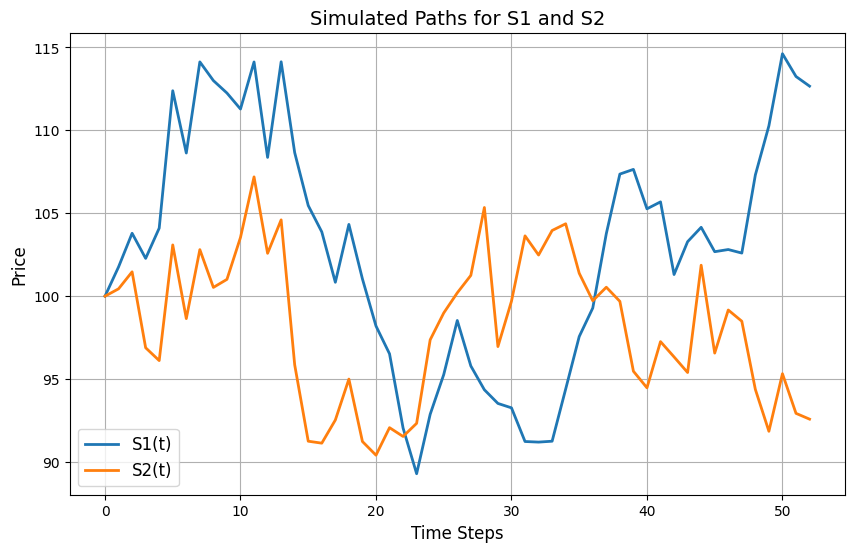

In [2]:
### DATA ###
r = 0.05                 # risk-free rate
q_1, q_2 = 0.02, 0.02    # dividend yields of stock 1 and stock 2
v_1, v_2 = 0.2, 0.25     # volatilities of stock 1 and stock 2
rho = 0.5                # correlation
S0_1, S0_2 = 100, 100    # starting prices of stock 1 and stock 2
b = 120                  # barrier value for stock 1
K = 120                  # strike value for stock 2
T = 1                    # maturity
m = 52                   # monitoring frequency (weekly)
n_sim = 10000            # number of simulations


### MONTECARLO SIMULATION ###
dt = T/m

S1 = np.zeros(shape = (n_sim, m+1))
S2 = np.zeros(shape = (n_sim, m+1))

S1[:, 0] = S0_1
S2[:, 0] = S0_2

Z1 = np.random.normal(0, 1, (n_sim, m))
Z2 = np.random.normal(0, 1, (n_sim, m))

for j in range(m):
    S1[:,j+1] = S1[:,j] * np.exp((r - q_1 - 0.5 * v_1**2) * dt + v_1 * np.sqrt(dt) * Z1[:,j])
    S2[:,j+1] = S2[:,j] * np.exp((r - q_2 - 0.5 * v_2**2) * dt + v_2 * np.sqrt(dt) * (rho * Z1[:,j] + np.sqrt(1 - rho**2) * Z2[:,j]))

# plot of a single simulated path
plt.figure(figsize=(10, 6))
plt.plot(S1[0, :], label="S1(t)", linewidth=2)
plt.plot(S2[0, :], label="S2(t)", linewidth=2)
plt.title("Simulated Paths for S1 and S2", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [3]:
# price computation using the montecarlo simulation of the previous cell
M_1 = np.max(S1[:, 1:], axis=1)

S2_T = S2[:, -1]

call_payoff = np.maximum(S2_T - K, 0)

barrier_indicator = (M_1 >= b).astype(float)

knock_in_payoff = call_payoff * barrier_indicator

option_price = np.exp(-r * T) * np.mean(knock_in_payoff)

print(f"Monte Carlo estimate of the knock-in call option price: {option_price:.4f}")

Monte Carlo estimate of the knock-in call option price: 2.8310


In [4]:
# creation of the function that computes the price of a standard KI through montecarlo
def monte_carlo_knock_in(S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99,  Z1=None, Z2=None, random = True):
    dt = T / m

    S1 = np.zeros((n_sim, m + 1))
    S2 = np.zeros((n_sim, m + 1))
    S1[:, 0] = S0_1
    S2[:, 0] = S0_2

    if random == False:
      np.random.seed(69)

    if Z1 is None:
        Z1 = np.random.normal(0, 1, (n_sim, m))
    if Z2 is None:
        Z2 = np.random.normal(0, 1, (n_sim, m))

    for j in range(m):
      S1[:,j+1] = S1[:,j] * np.exp((r - q_1 - 0.5 * v_1**2) * dt + v_1 * np.sqrt(dt) * Z1[:,j])
      S2[:,j+1] = S2[:,j] * np.exp((r - q_2 - 0.5 * v_2**2) * dt + v_2 * np.sqrt(dt) * (rho * Z1[:,j] + np.sqrt(1 - rho**2) * Z2[:,j]))

    M_1 = np.max(S1[:, 1:], axis=1)
    S2_T = S2[:, -1]

    call_payoff = np.maximum(S2_T - K, 0)
    barrier_indicator = (M_1 >= b).astype(float)
    knock_in_payoff = call_payoff * barrier_indicator
    discounted_payoff = np.exp(-r * T) * knock_in_payoff

    option_price = np.exp(-r * T) * np.mean(knock_in_payoff)

    # here we added the computation for the confidence interval
    std_error = np.std(knock_in_payoff) / np.sqrt(n_sim)
    confidence_interval_95 = norm.interval(alpha1, loc=option_price, scale=std_error)
    confidence_interval_99 = norm.interval(alpha2, loc=option_price, scale=std_error)


    return option_price, confidence_interval_95, confidence_interval_99, discounted_payoff

**PLOTTING FOR BOTH 95% AND 99% CONFIDENCE INTERVALS**

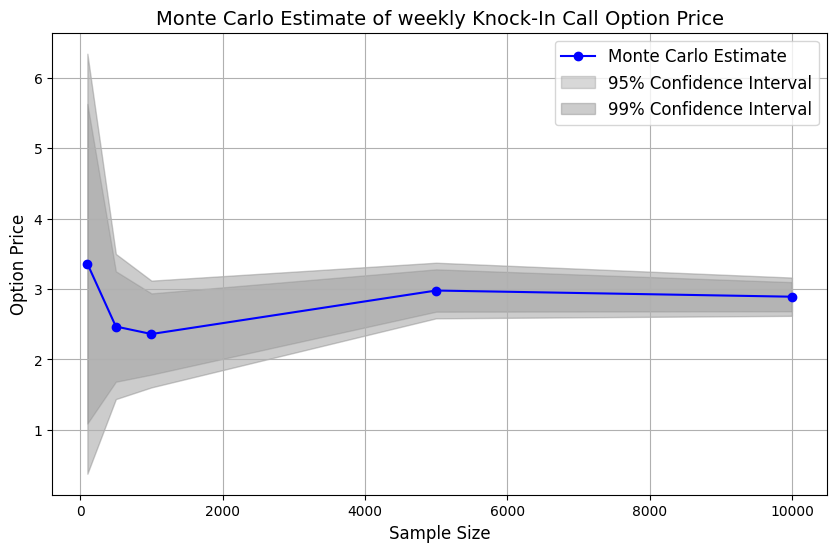

In [5]:
# starting data with WEEKLY monitoring frequency
r = 0.05
q_1, q_2 = 0.02, 0.02
v_1, v_2 = 0.2, 0.25
rho = 0.5
S0_1, S0_2 = 100, 100
b = 120
K = 120
T = 1
m = 52
n_sim_values = [100, 500, 1000, 5000, 10000]  # different sample sizes


### SIMULATION ###
dt = T / m

results = []
for n_sim in n_sim_values:
    price, ci_95, ci_99, _ = monte_carlo_knock_in(
                S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, random = False
            )
    results.append((n_sim, price, ci_95[0], ci_95[1], ci_99[0], ci_99[1]))

# the array results contains both price, number of simulations, and confidence interval bounds
results = np.array(results)

### PLOT ###
plt.figure(figsize=(10, 6))
plt.plot(results[:, 0], results[:, 1], label="Monte Carlo Estimate", color='blue', marker='o')
plt.fill_between(results[:, 0], results[:, 2], results[:, 3], color='gray', alpha=0.3, label="95% Confidence Interval")
plt.fill_between(results[:, 0], results[:, 4], results[:, 5], color='gray', alpha=0.4, label="99% Confidence Interval")


plt.title("Monte Carlo Estimate of weekly Knock-In Call Option Price", fontsize=14)
plt.xlabel("Sample Size", fontsize=12)
plt.ylabel("Option Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

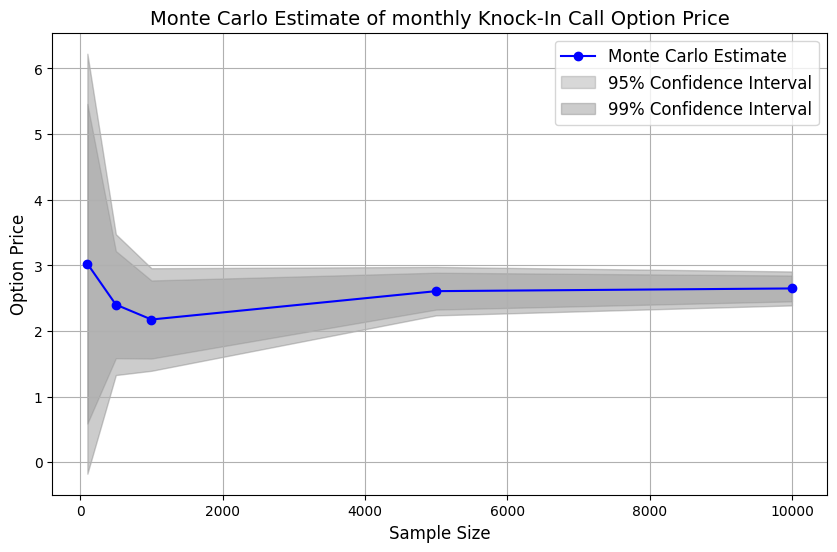

In [6]:
# here we changed to MONTHLY monitoring frequency
m = 12

### SIMULATION ###
dt = T / m

results = []
for n_sim in n_sim_values:
    price, ci_95, ci_99, _ = monte_carlo_knock_in(
                S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, random = False
            )
    results.append((n_sim, price, ci_95[0], ci_95[1],ci_99[0],ci_99[1]))

results = np.array(results)

### PLOT ###
plt.figure(figsize=(10, 6))
plt.plot(results[:, 0], results[:, 1], label="Monte Carlo Estimate", color='blue', marker='o')
plt.fill_between(results[:, 0], results[:, 2], results[:, 3], color='gray', alpha=0.3, label="95% Confidence Interval")
plt.fill_between(results[:, 0], results[:, 4], results[:, 5], color='gray', alpha=0.4, label="99% Confidence Interval")


plt.title("Monte Carlo Estimate of monthly Knock-In Call Option Price", fontsize=14)
plt.xlabel("Sample Size", fontsize=12)
plt.ylabel("Option Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

**ANALYSIS OF CONFIDENCE INTERVAL AS WE INCREASE THE MONITORING DAYS**

[[np.float64(6.0), np.float64(100.0), np.float64(2.6011739655505024), np.float64(0.6812446673390828), np.float64(4.521103263761922)], [np.float64(12.0), np.float64(100.0), np.float64(2.705736087012191), np.float64(0.7523831182726639), np.float64(4.659089055751718)], [np.float64(24.0), np.float64(100.0), np.float64(2.812489539389761), np.float64(0.8362053672900812), np.float64(4.7887737114894415)], [np.float64(52.0), np.float64(100.0), np.float64(2.8949162590843347), np.float64(0.8978234371240116), np.float64(4.892009081044658)], [np.float64(100.0), np.float64(100.0), np.float64(2.9382827846427686), np.float64(0.9231713334163107), np.float64(4.953394235869227)], [np.float64(250.0), np.float64(100.0), np.float64(2.969373572837677), np.float64(0.9542273137240863), np.float64(4.9845198319512685)]]


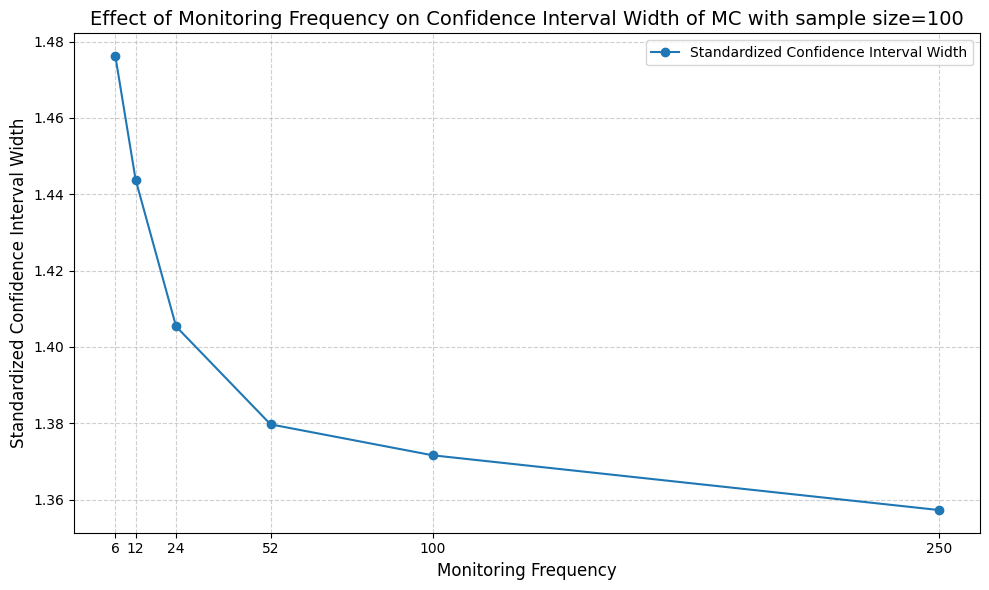

In [7]:
# analysis of the confidence interval at 95% as we increase monitoring frequency
# here we used a sample size of 100, that is a montecarlo on 100 simulations (results are consistent with every sample size)
# the montecarlo is executed 5000 times on each monitoring frequency

interval_analysis = []
m_values = [6,12,24,52,100,250]   # monitoring frequency
n_sim = 100

# for each monitoring frequency...
for m in m_values:
    support_array = []

    # ...we compute 5000 montecarlo estimates...
    for i in range(5000):
        # montecarlo function without the seed, that we will use to simulate many different montecarlos and average them out
        price, ci_95, ci_99, _ = monte_carlo_knock_in(S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, random = True)

        # ...we take the confidence interval bounds...
        support_array.append((m,n_sim, price, ci_95[0], ci_95[1] ))

    # ...and then take the average of the bounderies among the 5000 simulations...
    transposed = np.transpose(support_array)
    averages = [np.average(transposed[i]) for i in range(len(transposed))]

    # ...and store them for each monitoring frequency.
    interval_analysis.append(averages)



print(interval_analysis)

# creation of an array where we store the STANDARDIZED differences between upper and lower bound for each monitoring frequency
analysis_100_sample_size = []
for vector in interval_analysis:
  analysis_100_sample_size.append((vector[4]-vector[3])/vector[2]) #standardize the confidence interval by the price

### PLOT ###
plt.figure(figsize=(10, 6))
plt.plot(m_values, analysis_100_sample_size, marker='o', linestyle='-', label='Standardized Confidence Interval Width')
plt.title('Effect of Monitoring Frequency on Confidence Interval Width of MC with sample size=100', fontsize=14)
plt.xlabel('Monitoring Frequency', fontsize=12)
plt.ylabel('Standardized Confidence Interval Width', fontsize=12)
plt.xticks(m_values)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

Although showing some variability due to simulation, we consistently see a downward trend in the standardized confidence interval width.

This means that as the monitoring frequency increases, the precision of the simulation generally improves, leading to narrower confidence intervals (when adjusting for the increase in the option price). This is because the variance of the estimator typically decreases with finer monitoring, assuming all else is constant.

**ANALYSIS ON PRICE BEHAVIOUR BASED ON DIFFERENT VOLATILITIES/CORRELATION**

In [8]:
# analysis on the price with v2 kept fixed
frequencies = [12, 52]

# different volatilities pairs (keeping v2 fixed)
volatility_scenarios = [
    (0.15, 0.2),
    (0.2, 0.2),
    (0.25, 0.2),
    (0.3, 0.2),
    (0.1, 0.2),
    (0.35, 0.2),
    (0.4, 0.2),
    (0.45, 0.2),
    (0.5, 0.2),
    (0.55, 0.2),
    (0.6, 0.2),
]

# different correlations
correlations = [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 0.9]

# creation of an array where we store different prices for different pairs of volatilities and correlations
n_sim = 10000
results = []
for m in frequencies:
    for v_1, v_2 in volatility_scenarios:
        for rho in correlations:
            option_price = monte_carlo_knock_in(
                S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, Z1=None, Z2=None, random = False
            )
            results.append({
                "Frequency": m,
                "v_1": v_1,
                "v_2": v_2,
                "rho": rho,
                "Option Price": option_price[0]
            })
print(n_sim)
results_df = pd.DataFrame(results)

10000


In [9]:
# analysis on the price with v1 kept fixed
frequencies = [12, 52]

# different volatilities pairs (keeping v1 fixed)
volatility_scenarios = [
    (0.2, 0.1),
    (0.2, 0.15),
    (0.2, 0.2),
    (0.2, 0.25),
    (0.2, 0.30),
    (0.2, 0.35),
    (0.2, 0.40),
    (0.2, 0.45),
    (0.2, 0.5),
    (0.2, 0.55),
    (0.2, 0.6),
]

# different correlations
correlations = [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 0.9]

# creation of an array where we store different prices for different pairs of volatilities and correlations
n_sim = 10000
results = []
for m in frequencies:
    for v_1, v_2 in volatility_scenarios:
        for rho in correlations:
            option_price = monte_carlo_knock_in(
                S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, Z1=None, Z2=None, random = False
            )
            results.append({
                "Frequency": m,
                "v_1": v_1,
                "v_2": v_2,
                "rho": rho,
                "Option Price": option_price[0]
            })
print(n_sim)
results2_df = pd.DataFrame(results)

10000


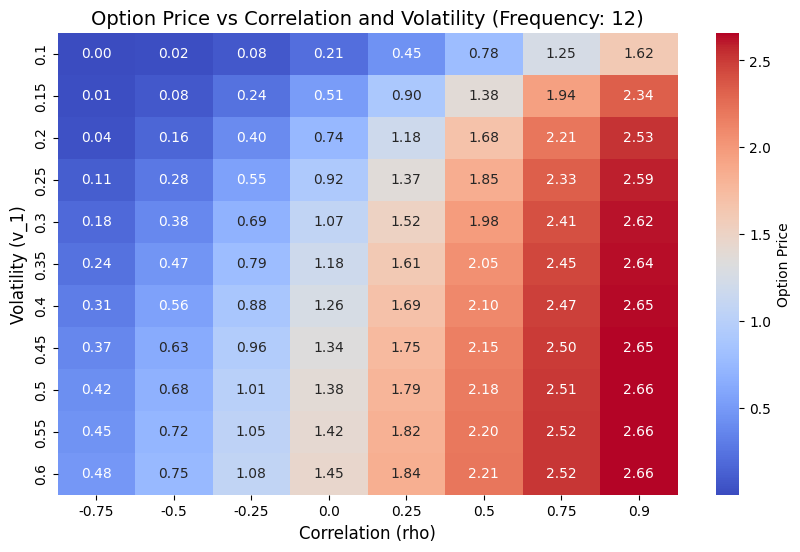

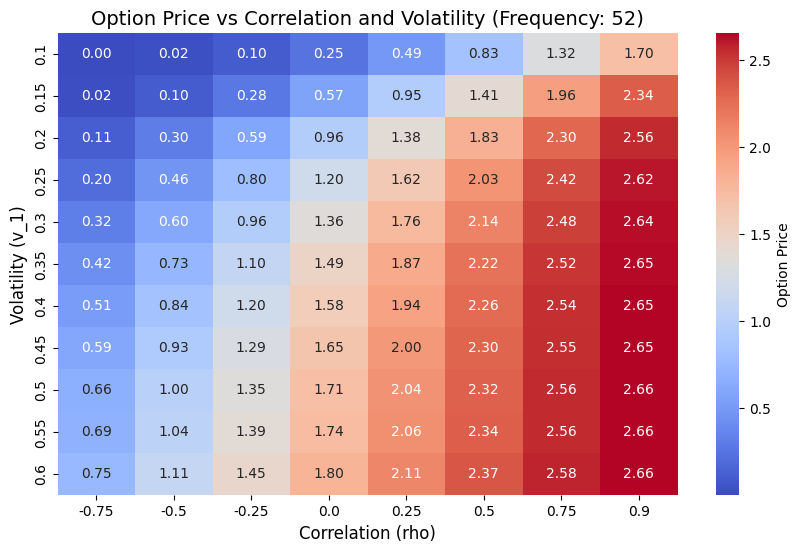

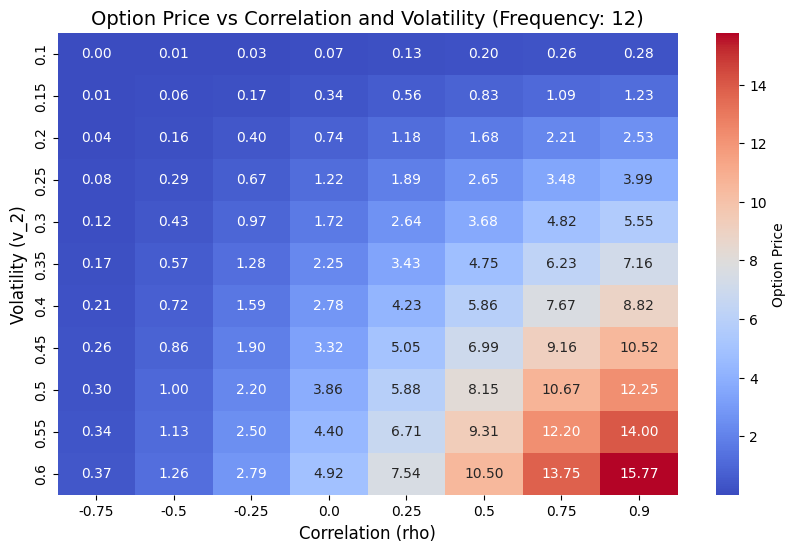

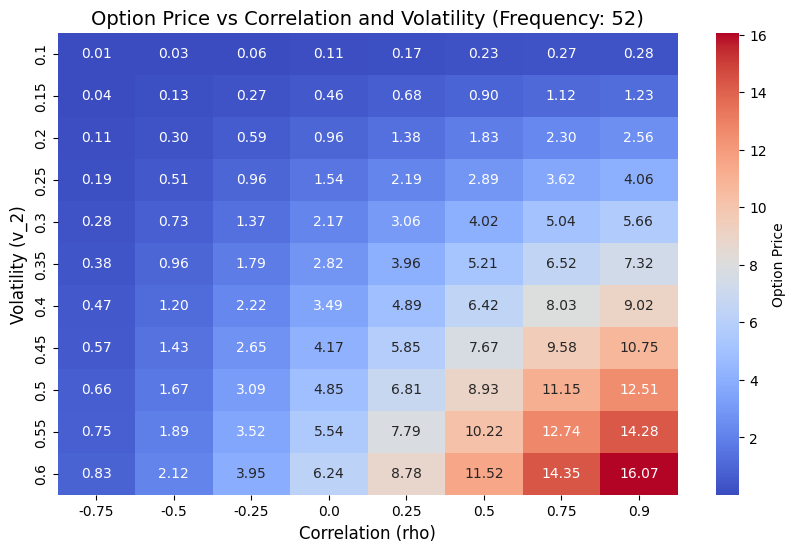

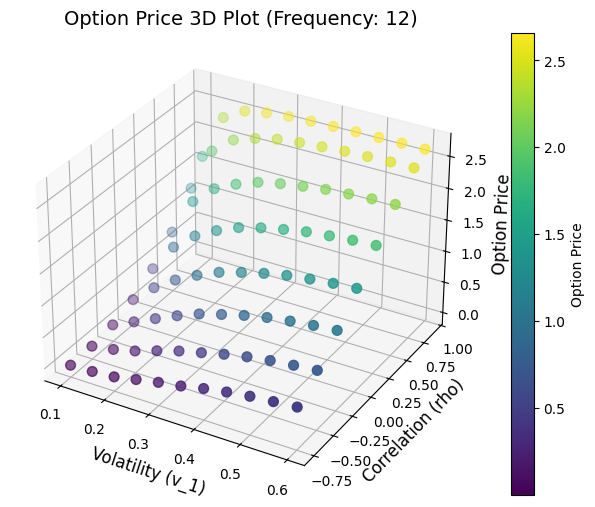

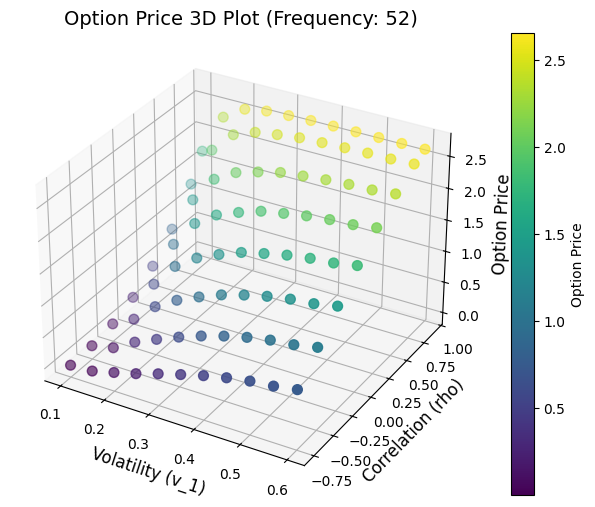

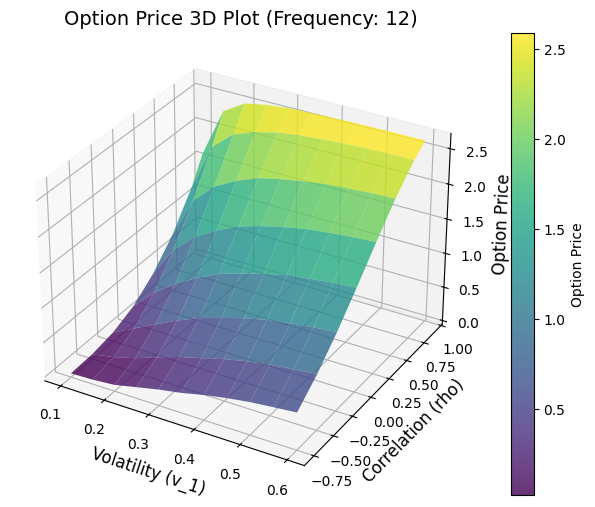

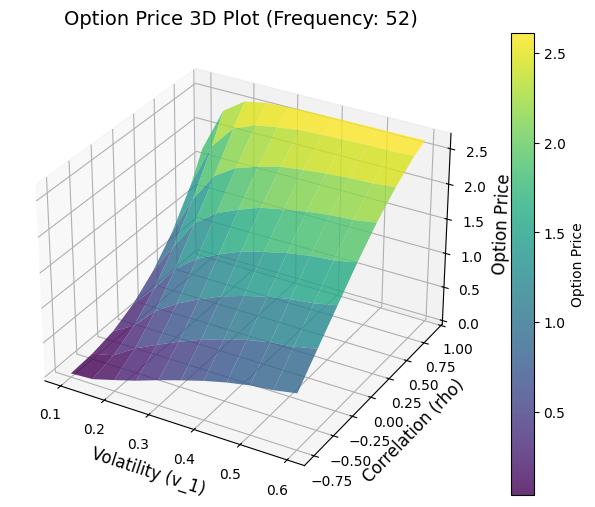

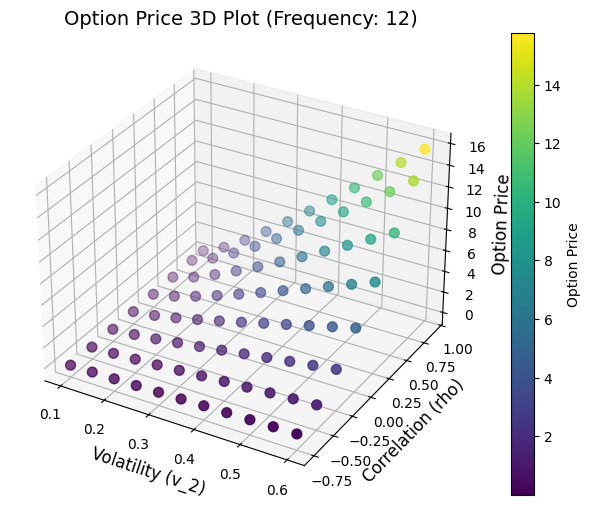

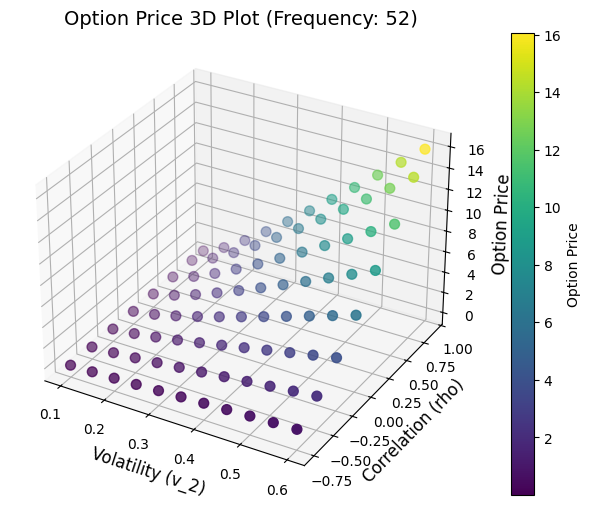

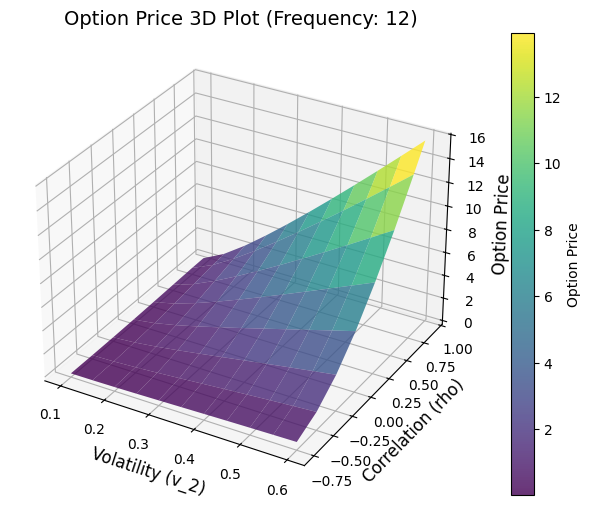

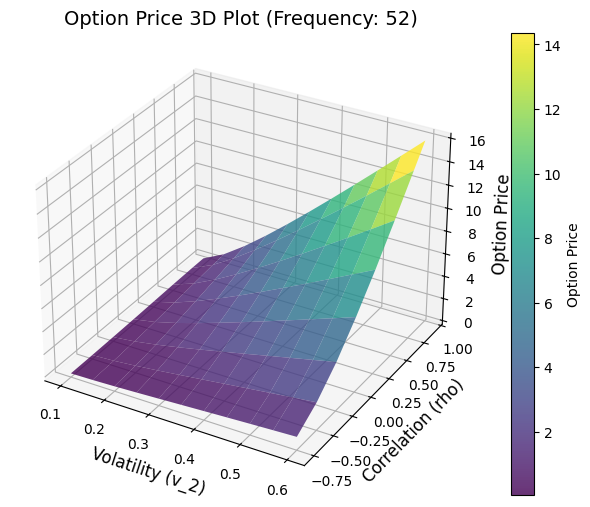

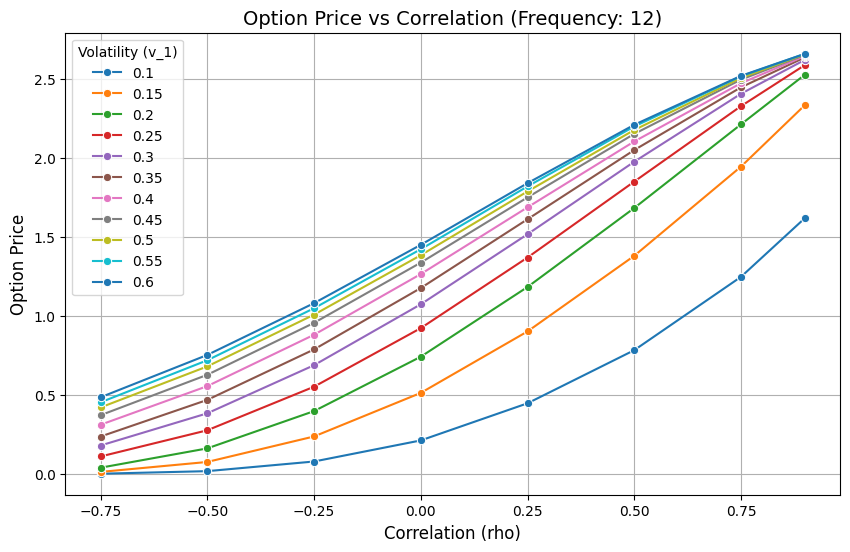

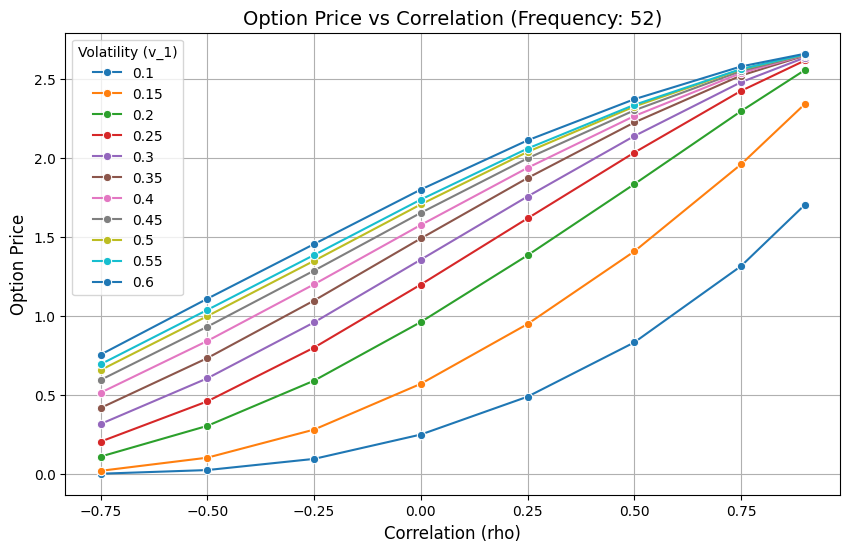

In [10]:
# Create a heatmap for a specific frequency to analyze the impact of correlation and volatilities
for freq in results_df["Frequency"].unique():
    freq_data = results_df[results_df["Frequency"] == freq]

    plt.figure(figsize=(10, 6))
    sns.heatmap(
    freq_data.pivot(index="v_1", columns="rho", values="Option Price"),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={'label': 'Option Price'}
    )
    plt.title(f"Option Price vs Correlation and Volatility (Frequency: {freq})", fontsize=14)
    plt.xlabel("Correlation (rho)", fontsize=12)
    plt.ylabel("Volatility (v_1)", fontsize=12)
    plt.show()

for freq in results2_df["Frequency"].unique():
    freq_data = results2_df[results2_df["Frequency"] == freq]

    plt.figure(figsize=(10, 6))
    sns.heatmap(
    freq_data.pivot(index="v_2", columns="rho", values="Option Price"),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={'label': 'Option Price'}
    )
    plt.title(f"Option Price vs Correlation and Volatility (Frequency: {freq})", fontsize=14)
    plt.xlabel("Correlation (rho)", fontsize=12)
    plt.ylabel("Volatility (v_2)", fontsize=12)
    plt.show()

# Create 3D plots for option price against volatility and correlation for all frequencies
for freq in results_df["Frequency"].unique():
    freq_data = results_df[results_df["Frequency"] == freq]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 3D Scatter Data
    x = freq_data["v_1"]
    y = freq_data["rho"]
    z = freq_data["Option Price"]

    scatter = ax.scatter(x, y, z, c=z, cmap="viridis", s=50)

    # Axis labels and title
    ax.set_title(f"Option Price 3D Plot (Frequency: {freq})", fontsize=14)
    ax.set_xlabel("Volatility (v_1)", fontsize=12)
    ax.set_ylabel("Correlation (rho)", fontsize=12)
    ax.set_zlabel("Option Price", fontsize=12)

    # Add color bar
    fig.colorbar(scatter, ax=ax, label="Option Price")
    plt.show()

#Create 3d graph for a given v2
for freq in results_df["Frequency"].unique():
    freq_data = results_df[results_df["Frequency"] == freq]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Pivot the data to create 2D arrays for surface plot
    # Create a 2D pivot table of Option Price based on v_1 and rho
    pivot_data = freq_data.pivot_table(index="rho", columns="v_1", values="Option Price")

    # Extract 2D arrays for x, y, and z
    x = pivot_data.columns.values  # v_1 values
    y = pivot_data.index.values    # rho values
    X, Y = np.meshgrid(x, y)       # Create mesh grid for the surface
    Z = pivot_data.values          # Option Price as Z values

    # Plot the surface
    surface = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.8)

    # Axis labels and title
    ax.set_title(f"Option Price 3D Plot (Frequency: {freq})", fontsize=14)
    ax.set_xlabel("Volatility (v_1)", fontsize=12)
    ax.set_ylabel("Correlation (rho)", fontsize=12)
    ax.set_zlabel("Option Price", fontsize=12)

    # Add color bar
    fig.colorbar(surface, ax=ax, label="Option Price")
    plt.show()

#Scatter plot for given v1
for freq in results2_df["Frequency"].unique():
    freq_data = results2_df[results_df["Frequency"] == freq]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 3D Scatter Data
    x = freq_data["v_2"]
    y = freq_data["rho"]
    z = freq_data["Option Price"]

    scatter = ax.scatter(x, y, z, c=z, cmap="viridis", s=50)

    # Axis labels and title
    ax.set_title(f"Option Price 3D Plot (Frequency: {freq})", fontsize=14)
    ax.set_xlabel("Volatility (v_2)", fontsize=12)
    ax.set_ylabel("Correlation (rho)", fontsize=12)
    ax.set_zlabel("Option Price", fontsize=12)

    # Add color bar
    fig.colorbar(scatter, ax=ax, label="Option Price")
    plt.show()

#Create 3d graph for a given v1
for freq in results2_df["Frequency"].unique():
    freq_data = results2_df[results_df["Frequency"] == freq]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Pivot the data to create 2D arrays for surface plot
    # Create a 2D pivot table of Option Price based on v_1 and rho
    pivot_data = freq_data.pivot_table(index="rho", columns="v_2", values="Option Price")

    # Extract 2D arrays for x, y, and z
    x = pivot_data.columns.values  # v_1 values
    y = pivot_data.index.values    # rho values
    X, Y = np.meshgrid(x, y)       # Create mesh grid for the surface
    Z = pivot_data.values          # Option Price as Z values

    # Plot the surface
    surface = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.8)

    # Axis labels and title
    ax.set_title(f"Option Price 3D Plot (Frequency: {freq})", fontsize=14)
    ax.set_xlabel("Volatility (v_2)", fontsize=12)
    ax.set_ylabel("Correlation (rho)", fontsize=12)
    ax.set_zlabel("Option Price", fontsize=12)

    # Add color bar
    fig.colorbar(surface, ax=ax, label="Option Price")
    plt.show()

# Line plot to analyze the effect of correlations on option price for fixed volatilities
for freq in results_df["Frequency"].unique():
    freq_data = results_df[results_df["Frequency"] == freq]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=freq_data, x="rho", y="Option Price", hue="v_1", marker="o", palette="tab10")
    plt.title(f"Option Price vs Correlation (Frequency: {freq})", fontsize=14)
    plt.xlabel("Correlation (rho)", fontsize=12)
    plt.ylabel("Option Price", fontsize=12)
    plt.legend(title="Volatility (v_1)", fontsize=10)
    plt.grid()
    plt.show()

## Barrier Digital Option   

Let $T = 1 \, \text{year}$ and consider a barrier $b > S_1(0)$ on the first asset $S_1$, monitored at discrete times $t_m = m \frac{T}{M}$ for $m = 1, \dots, M$. The barrier is activated if:  

$$M_1(T) = \max \{ S_1(t) : t \in \{t_1, \dots, t_M\} \} \geq b.$$

We also consider a standard digtal option on $S_2$ with maturity $T$ and strike price $K$, which has the payoff:  

$$
c(T) = \mathbb{I}_{\{S_2(T) \geq K\}},
$$  

where $\mathbb{I}_{\{S_2(T) \geq K\}}$ is the indicator function that takes the value 1 if the $S_2$ is higher than strike $K$, and 0 otherwise.

Now, we define the $S_1$-knock-in digital option on $S_2$, which has the payoff:  

$$
X(T) = c(T) \cdot \mathbb{I}_{\{M_1(T) \geq b\}} =  \mathbb{I}_{\{S_2(T) \geq K\}} \cdot \mathbb{I}_{\{M_1(T) \geq b\}},
$$  

where $\mathbb{I}_{\{M_1(T) \geq b\}}$ is the indicator function that takes the value 1 if the barrier $b$ is breached, and 0 otherwise.  

---

## Task  

Compute the Monte Carlo estimate of the price of the knock-in digital option $X(T)$ for different monitoring frequencies (e.g., weekly or monthly) and for various values of volatilities $(v_1, v_2)$ and correlation $( \rho)$.

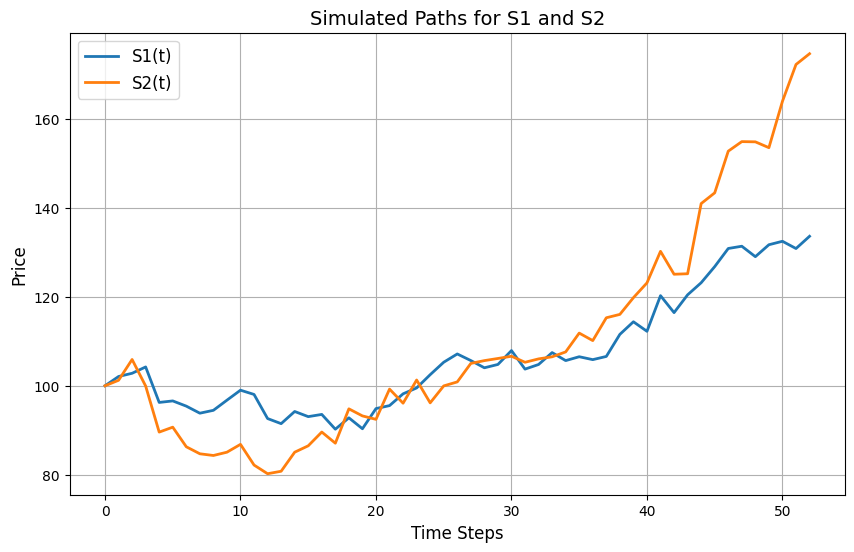

In [11]:
### DATA ###
r = 0.05
q_1, q_2 = 0.02, 0.02
v_1, v_2 = 0.2, 0.25
rho = 0.5
S0_1, S0_2 = 100, 100
b = 120
K = 120
T = 1
m = 52
n_sim = 10000

### MONTECARLO SIMULATION ###
dt = T/m

S1 = np.zeros(shape = (n_sim, m+1))
S2 = np.zeros(shape = (n_sim, m+1))

S1[:, 0] = S0_1
S2[:, 0] = S0_2

Z1 = np.random.normal(0, 1, (n_sim, m))
Z2 = np.random.normal(0, 1, (n_sim, m))

for j in range(m):
    S1[:,j+1] = S1[:,j] * np.exp((r - q_1 - 0.5 * v_1**2) * dt + v_1 * np.sqrt(dt) * Z1[:,j])
    S2[:,j+1] = S2[:,j] * np.exp((r - q_2 - 0.5 * v_2**2) * dt + v_2 * np.sqrt(dt) * (rho * Z1[:,j] + np.sqrt(1 - rho**2) * Z2[:,j]))

# plot of a single simulated path
plt.figure(figsize=(10, 6))
plt.plot(S1[0, :], label="S1(t)", linewidth=2)
plt.plot(S2[0, :], label="S2(t)", linewidth=2)
plt.title("Simulated Paths for S1 and S2", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [12]:
# price computation of the DIGITAL KI with the montecarlo simulation of the cell above
M_1 = np.max(S1[:, 1:], axis=1)

S2_T = S2[:, -1]

digital_payoff = (S2_T >= K).astype(float)

barrier_indicator = (M_1 >= b).astype(float)

payoff = digital_payoff * barrier_indicator

option_price = np.exp(-r * T) * np.mean(payoff)

print(f"Monte Carlo estimate of the knock-in digital option price: {option_price:.4f}")

Monte Carlo estimate of the knock-in digital option price: 0.1258


In [13]:
# creation of the function that computes the price of a DIGITAL KI through montecarlo
def monte_carlo_knock_in_digital(S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, Z1=None, Z2=None, random = True):
    dt = T / m

    S1 = np.zeros((n_sim, m + 1))
    S2 = np.zeros((n_sim, m + 1))
    S1[:, 0] = S0_1
    S2[:, 0] = S0_2

    if random == False:
      np.random.seed(69)

    if Z1 is None:
        Z1 = np.random.normal(0, 1, (n_sim, m))
    if Z2 is None:
        Z2 = np.random.normal(0, 1, (n_sim, m))

    for j in range(m):
      S1[:,j+1] = S1[:,j] * np.exp((r - q_1 - 0.5 * v_1**2) * dt + v_1 * np.sqrt(dt) * Z1[:,j])
      S2[:,j+1] = S2[:,j] * np.exp((r - q_2 - 0.5 * v_2**2) * dt + v_2 * np.sqrt(dt) * (rho * Z1[:,j] + np.sqrt(1 - rho**2) * Z2[:,j]))

    M_1 = np.max(S1[:, 1:], axis=1)
    S2_T = S2[:, -1]

    digital_payoff = (S2_T >= K).astype(float)
    barrier_indicator = (M_1 >= b).astype(float)
    payoff = digital_payoff * barrier_indicator
    discounted_payoff = np.exp(-r * T) * payoff
    option_price = np.exp(-r * T) * np.mean(payoff)

    # here we added the computation for the confidence interval
    std_error = np.std(payoff) / np.sqrt(n_sim)
    confidence_interval_95 = norm.interval(alpha1, loc=option_price, scale=std_error)
    confidence_interval_99 = norm.interval(alpha2, loc=option_price, scale=std_error)


    return option_price, confidence_interval_95, confidence_interval_99, discounted_payoff

**PLOTTING OF 95% AND 99% CONFIDENCE INTERVALS**

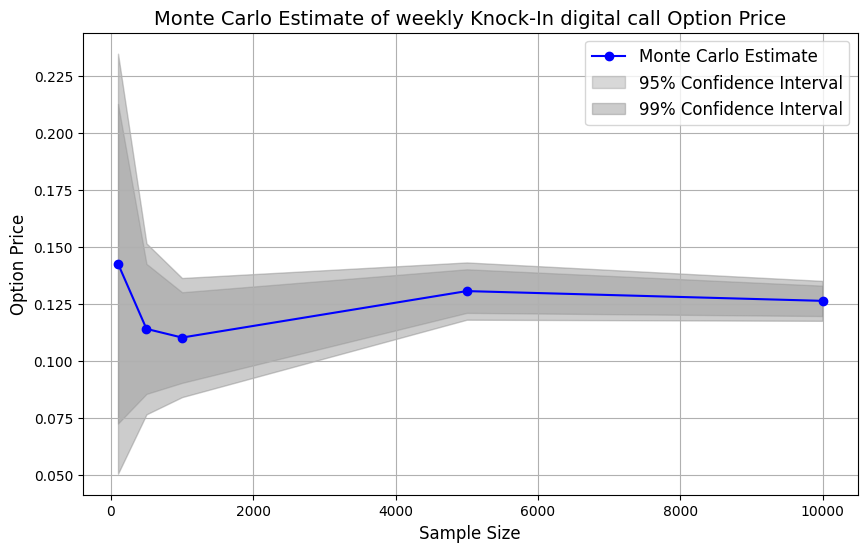

In [14]:
# starting data with WEEKLY monitoring frequency
r = 0.05
q_1, q_2 = 0.02, 0.02
v_1, v_2 = 0.2, 0.25
rho = 0.5
S0_1, S0_2 = 100, 100
b = 120
K = 120
T = 1
m = 52
n_sim_values = [100, 500, 1000, 5000, 10000]  # different sample sizes


### SIMULATION ###
dt = T / m

results = []
for n_sim in n_sim_values:
    price, ci_95, ci_99, _ = monte_carlo_knock_in_digital(
                S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, random = False
            )
    results.append((n_sim, price, ci_95[0], ci_95[1], ci_99[0], ci_99[1]))

# the array results contains both price, number of simulations, and confidence interval bounds
results = np.array(results)

### PLOT ###
plt.figure(figsize=(10, 6))
plt.plot(results[:, 0], results[:, 1], label="Monte Carlo Estimate", color='blue', marker='o')
plt.fill_between(results[:, 0], results[:, 2], results[:, 3], color='gray', alpha=0.3, label="95% Confidence Interval")
plt.fill_between(results[:, 0], results[:, 4], results[:, 5], color='gray', alpha=0.4, label="99% Confidence Interval")


plt.title("Monte Carlo Estimate of weekly Knock-In digital call Option Price", fontsize=14)
plt.xlabel("Sample Size", fontsize=12)
plt.ylabel("Option Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

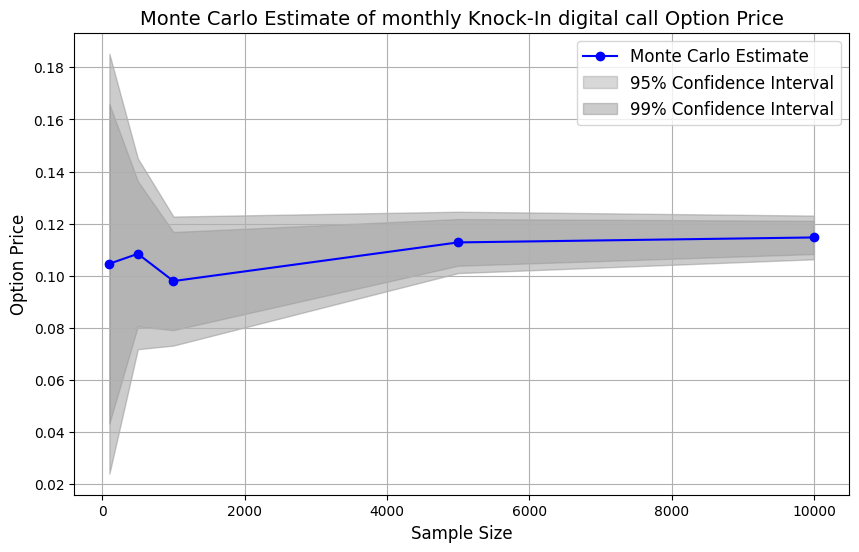

In [15]:
# starting data with MONTHLY monitoring frequency
m = 12
n_sim_values = [100, 500, 1000, 5000, 10000]  # different sample sizes


### SIMULATION ###
dt = T / m

results = []
for n_sim in n_sim_values:
    price, ci_95, ci_99, _ = monte_carlo_knock_in_digital(
                S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, random = False
            )
    results.append((n_sim, price, ci_95[0], ci_95[1], ci_99[0], ci_99[1]))

# the array results contains both price, number of simulations, and confidence interval bounds
results = np.array(results)

### PLOT ###
plt.figure(figsize=(10, 6))
plt.plot(results[:, 0], results[:, 1], label="Monte Carlo Estimate", color='blue', marker='o')
plt.fill_between(results[:, 0], results[:, 2], results[:, 3], color='gray', alpha=0.3, label="95% Confidence Interval")
plt.fill_between(results[:, 0], results[:, 4], results[:, 5], color='gray', alpha=0.4, label="99% Confidence Interval")


plt.title("Monte Carlo Estimate of monthly Knock-In digital call Option Price", fontsize=14)
plt.xlabel("Sample Size", fontsize=12)
plt.ylabel("Option Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

**PRICE BEHAVIOUR OF THE DIGITAL AS VOLATILITIES/CORRELATION CHANGE**

In [16]:
# analysis on the price with v2 kept fixed
frequencies = [12, 52]

# different volatilities pairs (keeping v2 fixed)
volatility_scenarios = [
    (0.15, 0.2),
    (0.2, 0.2),
    (0.25, 0.2),
    (0.3, 0.2),
    (0.1, 0.2),
    (0.35, 0.2),
    (0.4, 0.2),
    (0.45, 0.2),
    (0.5, 0.2),
    (0.55, 0.2),
    (0.6, 0.2),
]

# different correlations
correlations = [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 0.9]

# creation of an array where we store different prices for different pairs of volatilities and correlations
n_sim = 10000
results = []
for m in frequencies:
    for v_1, v_2 in volatility_scenarios:
        for rho in correlations:
            option_price = monte_carlo_knock_in_digital(
                S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, Z1=None, Z2=None, random = False
            )
            results.append({
                "Frequency": m,
                "v_1": v_1,
                "v_2": v_2,
                "rho": rho,
                "Option Price": option_price[0]
            })
print(n_sim)
results_df = pd.DataFrame(results)

10000


In [17]:
# analysis on the price with v1 kept fixed
frequencies = [12, 52]

# different volatilities pairs (keeping v1 fixed)
volatility_scenarios = [
    (0.2, 0.1),
    (0.2, 0.15),
    (0.2, 0.2),
    (0.2, 0.25),
    (0.2, 0.30),
    (0.2, 0.35),
    (0.2, 0.40),
    (0.2, 0.45),
    (0.2, 0.5),
    (0.2, 0.55),
    (0.2, 0.6),
]

# different correlations
correlations = [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 0.9]

# creation of an array where we store different prices for different pairs of volatilities and correlations
n_sim = 10000
results = []
for m in frequencies:
    for v_1, v_2 in volatility_scenarios:
        for rho in correlations:
            option_price = monte_carlo_knock_in_digital(
                S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, alpha1=0.95, alpha2=0.99, Z1=None, Z2=None, random = False
            )
            results.append({
                "Frequency": m,
                "v_1": v_1,
                "v_2": v_2,
                "rho": rho,
                "Option Price": option_price[0]
            })
print(n_sim)
results2_df = pd.DataFrame(results)

10000


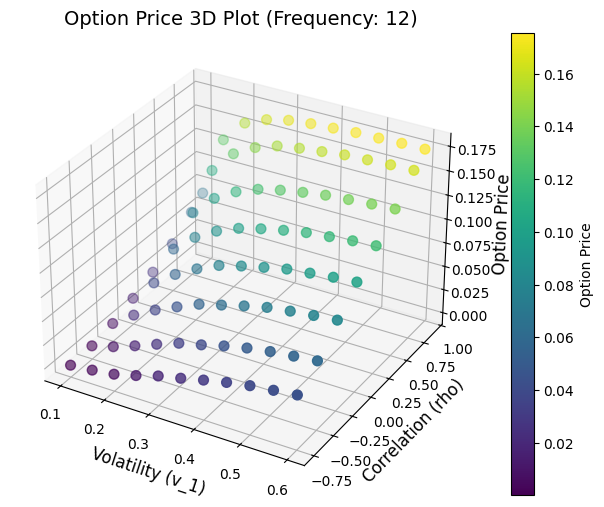

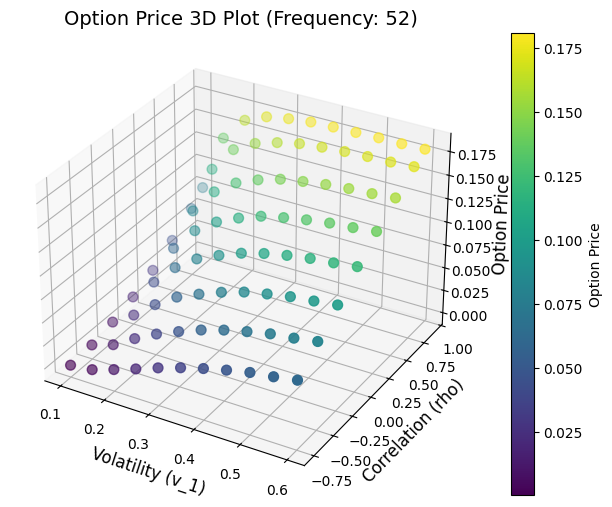

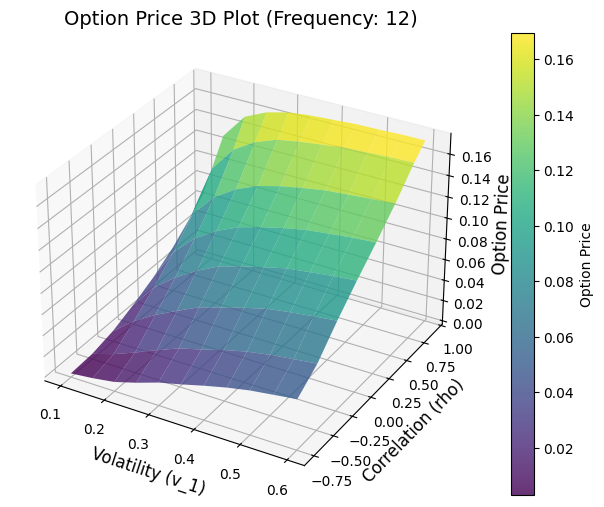

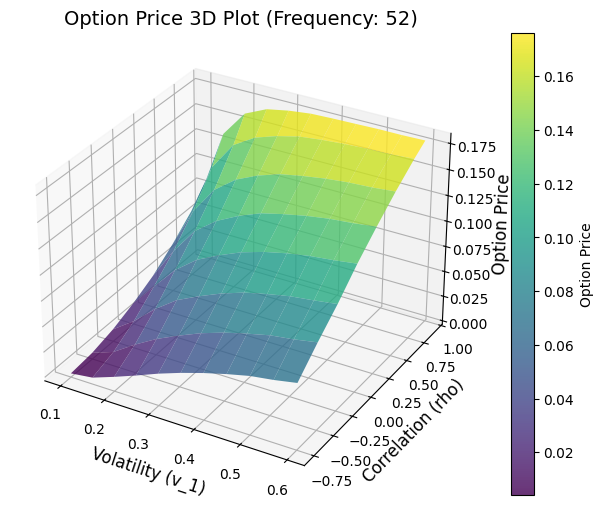

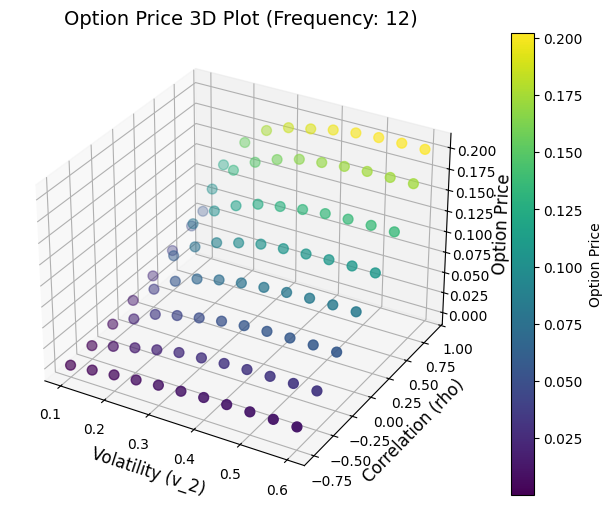

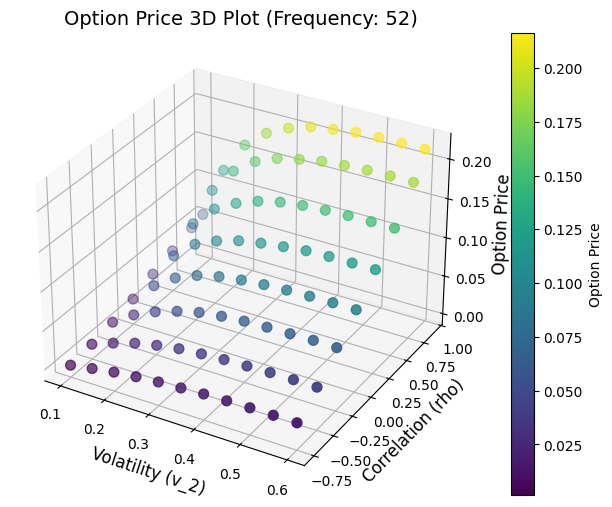

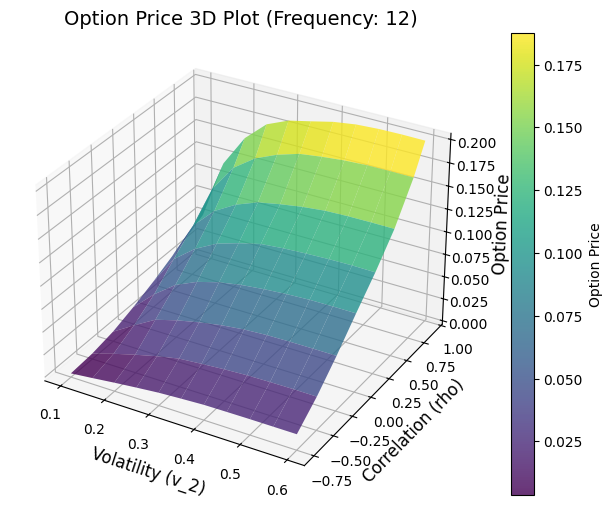

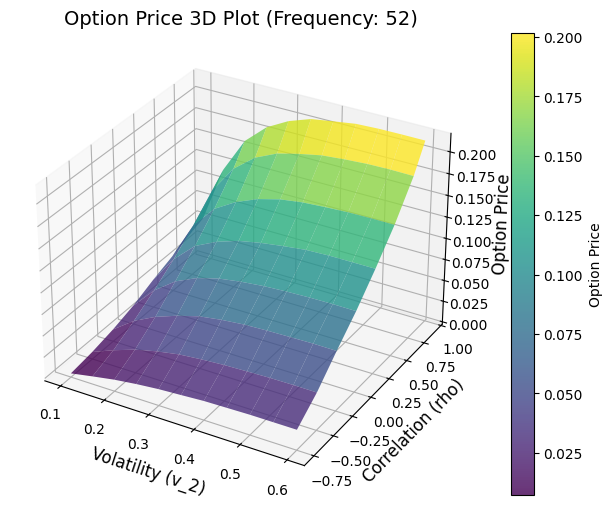

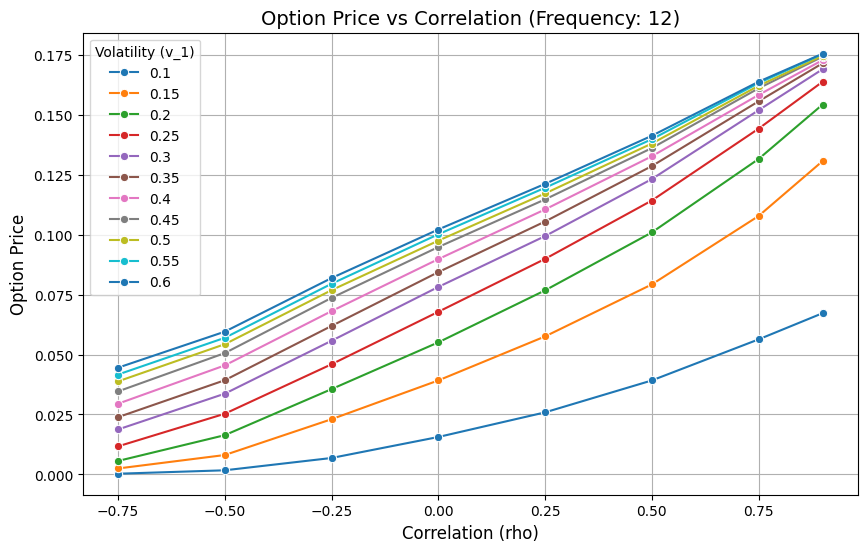

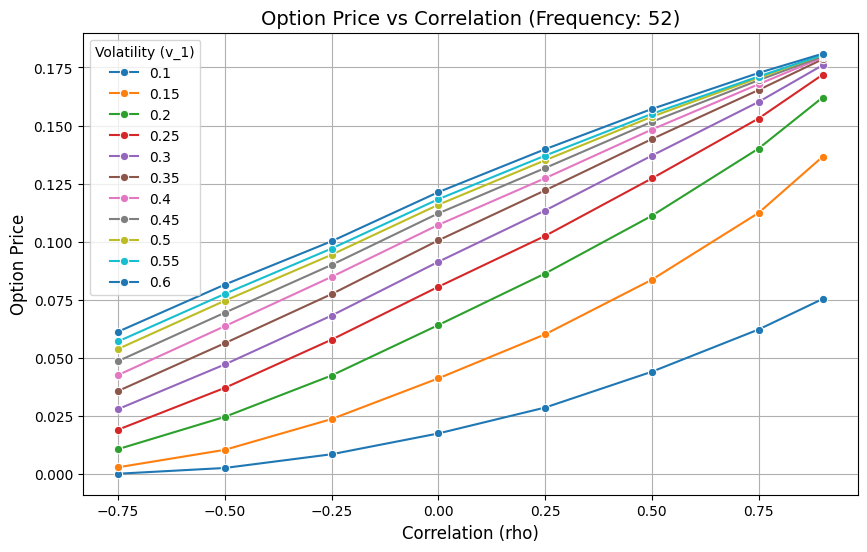

In [18]:
# Create 3D plots for option price against volatility and correlation for all frequencies
for freq in results_df["Frequency"].unique():
    freq_data = results_df[results_df["Frequency"] == freq]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 3D Scatter Data
    x = freq_data["v_1"]
    y = freq_data["rho"]
    z = freq_data["Option Price"]

    scatter = ax.scatter(x, y, z, c=z, cmap="viridis", s=50)

    # Axis labels and title
    ax.set_title(f"Option Price 3D Plot (Frequency: {freq})", fontsize=14)
    ax.set_xlabel("Volatility (v_1)", fontsize=12)
    ax.set_ylabel("Correlation (rho)", fontsize=12)
    ax.set_zlabel("Option Price", fontsize=12)

    # Add color bar
    fig.colorbar(scatter, ax=ax, label="Option Price")
    plt.show()

#Create 3d graph for a given v2
for freq in results_df["Frequency"].unique():
    freq_data = results_df[results_df["Frequency"] == freq]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Pivot the data to create 2D arrays for surface plot
    # Create a 2D pivot table of Option Price based on v_1 and rho
    pivot_data = freq_data.pivot_table(index="rho", columns="v_1", values="Option Price")

    # Extract 2D arrays for x, y, and z
    x = pivot_data.columns.values  # v_1 values
    y = pivot_data.index.values    # rho values
    X, Y = np.meshgrid(x, y)       # Create mesh grid for the surface
    Z = pivot_data.values          # Option Price as Z values

    # Plot the surface
    surface = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.8)

    # Axis labels and title
    ax.set_title(f"Option Price 3D Plot (Frequency: {freq})", fontsize=14)
    ax.set_xlabel("Volatility (v_1)", fontsize=12)
    ax.set_ylabel("Correlation (rho)", fontsize=12)
    ax.set_zlabel("Option Price", fontsize=12)

    # Add color bar
    fig.colorbar(surface, ax=ax, label="Option Price")
    plt.show()

#Scatter plot for given v1
for freq in results2_df["Frequency"].unique():
    freq_data = results2_df[results_df["Frequency"] == freq]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 3D Scatter Data
    x = freq_data["v_2"]
    y = freq_data["rho"]
    z = freq_data["Option Price"]

    scatter = ax.scatter(x, y, z, c=z, cmap="viridis", s=50)

    # Axis labels and title
    ax.set_title(f"Option Price 3D Plot (Frequency: {freq})", fontsize=14)
    ax.set_xlabel("Volatility (v_2)", fontsize=12)
    ax.set_ylabel("Correlation (rho)", fontsize=12)
    ax.set_zlabel("Option Price", fontsize=12)

    # Add color bar
    fig.colorbar(scatter, ax=ax, label="Option Price")
    plt.show()

#Create 3d graph for a given v1
for freq in results2_df["Frequency"].unique():
    freq_data = results2_df[results_df["Frequency"] == freq]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Pivot the data to create 2D arrays for surface plot
    # Create a 2D pivot table of Option Price based on v_1 and rho
    pivot_data = freq_data.pivot_table(index="rho", columns="v_2", values="Option Price")

    # Extract 2D arrays for x, y, and z
    x = pivot_data.columns.values  # v_1 values
    y = pivot_data.index.values    # rho values
    X, Y = np.meshgrid(x, y)       # Create mesh grid for the surface
    Z = pivot_data.values          # Option Price as Z values

    # Plot the surface
    surface = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.8)

    # Axis labels and title
    ax.set_title(f"Option Price 3D Plot (Frequency: {freq})", fontsize=14)
    ax.set_xlabel("Volatility (v_2)", fontsize=12)
    ax.set_ylabel("Correlation (rho)", fontsize=12)
    ax.set_zlabel("Option Price", fontsize=12)

    # Add color bar
    fig.colorbar(surface, ax=ax, label="Option Price")
    plt.show()

# Line plot to analyze the effect of correlations on option price for fixed volatilities
for freq in results_df["Frequency"].unique():
    freq_data = results_df[results_df["Frequency"] == freq]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=freq_data, x="rho", y="Option Price", hue="v_1", marker="o", palette="tab10")
    plt.title(f"Option Price vs Correlation (Frequency: {freq})", fontsize=14)
    plt.xlabel("Correlation (rho)", fontsize=12)
    plt.ylabel("Option Price", fontsize=12)
    plt.legend(title="Volatility (v_1)", fontsize=10)
    plt.grid()
    plt.show()

Price increases as both volatility 1 and volatility 2 increase.
The behaviour related to volatility 1 is the same as the case for a standard KI option, so, the higher the correlation, the lower the bound where this volatility stops effecting the price.

The behaviour related to volatility 2 is slightly different from the standard KI case. While in that case the slope of the price given the volatility is almost constant, we can see here that is decreasing. This makes sense because the payoff is constant and doesn't depend on the price level of S2, so extra volatility doesn't increase our possible payoff.


# Greeks

Greeks for KI call:

In [19]:
# function for the computations of greeks through the Central-Difference Estimator (CDE)
def compute_greeks(monte_carlo_function, S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, epsilon=0.01, alpha=0.95):
    """
    Compute Greeks (Delta, Gamma, Vega) using the central difference estimator.
    """
    # Base option price
    Z1 = np.random.normal(0, 1, (n_sim, m))
    Z2 = np.random.normal(0, 1, (n_sim, m))
    base_price = monte_carlo_function(S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]

    # Delta for S1
    epsilon_S1 = epsilon * S0_1
    delta_S1_up = monte_carlo_function(S0_1 + epsilon_S1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]
    delta_S1_down = monte_carlo_function(S0_1 - epsilon_S1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]
    delta_S1 = (delta_S1_up - delta_S1_down) / (2 * epsilon_S1)

    # Gamma for S1
    gamma_S1 = (delta_S1_up - 2 * base_price + delta_S1_down) / (epsilon_S1 ** 2)

    # Delta for S2
    epsilon_S2 = epsilon * S0_2
    delta_S2_up = monte_carlo_function(S0_1, S0_2 + epsilon_S2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]
    delta_S2_down = monte_carlo_function(S0_1, S0_2 - epsilon_S2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]
    delta_S2 = (delta_S2_up - delta_S2_down) / (2 * epsilon_S2)

    # Gamma for S2
    gamma_S2 = (delta_S2_up - 2 * base_price + delta_S2_down) / (epsilon_S2 ** 2)

    # Vega for v_1
    vega_1_up = monte_carlo_function(S0_1, S0_2, b, K, T, r, q_1, q_2, v_1 + epsilon, v_2, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]
    vega_1_down = monte_carlo_function(S0_1, S0_2, b, K, T, r, q_1, q_2, v_1 - epsilon, v_2, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]
    vega_1 = (vega_1_up - vega_1_down) / (2 * epsilon)

    # Vega for v_2
    vega_2_up = monte_carlo_function(S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2 + epsilon, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]
    vega_2_down = monte_carlo_function(S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2 - epsilon, rho, n_sim, m, Z1=Z1, Z2=Z2)[0]
    vega_2 = (vega_2_up - vega_2_down) / (2 * epsilon)

    return {
        "Delta (S1)": delta_S1,
        "Gamma (S1)": gamma_S1,
        "Delta (S2)": delta_S2,
        "Gamma (S2)": gamma_S2,
        "Vega (v_1)": vega_1,
        "Vega (v_2)": vega_2,
    }

In [20]:
r = 0.05
q_1, q_2 = 0.02, 0.02
v_1, v_2 = 0.2, 0.25
rho = 0.5
S0_1, S0_2 = 100, 100
b = 120
K = 120
T = 1
m = 52
n_sim = 40000

In [21]:
# greeks for the standard KI
np.random.seed(123)
greeks = compute_greeks(monte_carlo_knock_in, S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m)
print("Option Greeks:")
for greek, value in greeks.items():
    print(f"{greek}: {value:.4f}")

Option Greeks:
Delta (S1): 0.1037
Gamma (S1): -0.0040
Delta (S2): 0.1847
Gamma (S2): 0.0062
Vega (v_1): 7.6356
Vega (v_2): 22.6026


Greeks for KI digital:

In [22]:
# greeks for the DIGITAL KI
np.random.seed(123)
greeks = compute_greeks(monte_carlo_knock_in_digital, S0_1, S0_2, b, K, T, r, q_1, q_2, v_1, v_2, rho, n_sim, m)
print("Option Greeks:")
for greek, value in greeks.items():
    print(f"{greek}: {value:.4f}")

Option Greeks:
Delta (S1): 0.0057
Gamma (S1): -0.0002
Delta (S2): 0.0052
Gamma (S2): 0.0002
Vega (v_1): 0.4411
Vega (v_2): 0.2556
